In [42]:
import os
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from IPython import display
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg

In [43]:
root_path = r"E:\data_share_ths\dataset\CelebAMask-HQ\CelebAMask-HQ"

img_path = root_path+"\\CelebA-HQ-img"

anno_path = root_path+"\\CelebAMask-HQ-mask-anno"

mapping_path = root_path+"\\CelebA-HQ-to-CelebA-mapping.txt"

In [44]:
import os
_anno_paths = []
_anno_ids = []
_anno_parts = []
_image_names = []

for cur_folder in os.listdir(anno_path):
    cur_path = anno_path+"\\"+cur_folder
    for img_name in os.listdir(cur_path):
        face_id,face_part  = "",""
        temps = img_name.split("_")
        if len(temps) == 2:
            face_id,face_part = temps[0],temps[1]
        else:
            face_id,face_part = temps[0],temps[1]+"_"+temps[2]
        
        _anno_paths.append(cur_path+"\\"+img_name)
        _anno_ids.append(face_id)
        _anno_parts.append(face_part.split(".")[0])
        _image_names.append(img_name)

In [45]:
dist_parts = set(_anno_parts)
print(len(dist_parts))
dist_parts

18


{'cloth',
 'ear_r',
 'eye_g',
 'hair',
 'hat',
 'l_brow',
 'l_ear',
 'l_eye',
 'l_lip',
 'mouth',
 'neck',
 'neck_l',
 'nose',
 'r_brow',
 'r_ear',
 'r_eye',
 'skin',
 'u_lip'}

In [46]:

def read_image(img_pathList):
    temp = []
    for cur_path in img_pathList:
        img = cv2.imread(cur_path)
        temp.append(img)
    return temp

In [47]:
def plotImages(image_list,image_names):
    fig = plt.figure(figsize=(12, 12))
    cols = 6
    rows = int(len(image_list)/cols)
    for i in range(0, rows*cols):
        fig.add_subplot(rows, cols, i+1).set_title(image_names[i])
        plt.axis('off')
        plt.imshow(image_list[i])
    
    plt.show()

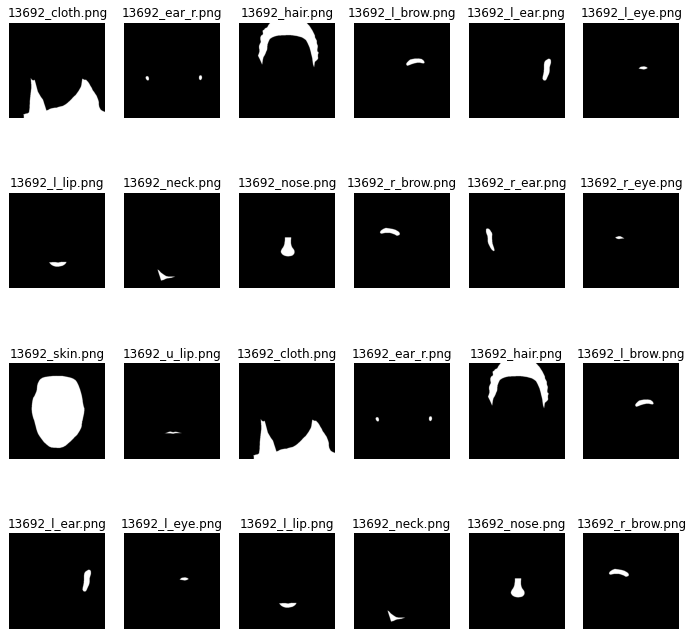

Random Id :  13692


In [48]:
random_id = random.choice(_anno_ids)
random_id_parts = []
random_names = []
while len(random_id_parts)<=18:
    for curImgname,curPath in  zip(_image_names,_anno_paths):
        if random_id in curImgname:
            random_id_parts.append(curPath)
            random_names.append(curImgname)
            continue
part_imgs = read_image(random_id_parts)

plotImages(part_imgs,random_names)
print("Random Id : ",int(random_id))

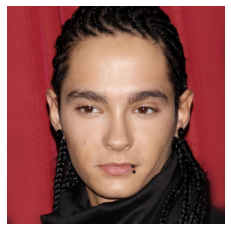

In [49]:
random_img_path = img_path+"\\"+str(int(random_id))+".jpg"
random_img = cv2.imread(random_img_path)
random_img = cv2.cvtColor(random_img,cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(random_img)

## Prepare Images

In [50]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
CHANNEL = 3

In [51]:
def read_img(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    return img

In [52]:
def create_emptyImage(img_width,img_height,channel):
    img= np.zeros((img_width,img_height,channel),dtype=int)
    return img

In [53]:
def get_parts(img_id):
    _img_parts = []
    _img_paths = []
    for anno_img_id,anno_path,anno_part  in zip(_anno_ids,_anno_paths,_anno_parts):
       
        if int(anno_img_id) == img_id:
            _img_paths.append(anno_path)
            _img_parts.append(anno_part)
    return _img_parts,_img_paths

In [54]:
def read_allParts(_img_parts,_img_paths):
    """
     l_brow,r_brow,l_eye,r_eye,nose,mouth,
     u_lip,l_lip,eye_g,ear_r,l_ear,r_ear,
     neck,neck_l,cloth,skin,hair,hat
     """
    input_list = ["l_brow","r_brow","l_eye","r_eye","nose","mouth",
     "u_lip","l_lip","eye_g","ear_r","l_ear","r_ear",
     "neck","neck_l","cloth","skin","hair","hat"]
    img_list = []
    
    for cur_class in input_list:
        cur_class_imgPath = None
        for img_part,img_path in zip(_img_parts,_img_paths):
            
            if cur_class == img_part:
                cur_class_imgPath = img_path
                break
        
        if cur_class_imgPath is None:
            emptyImg = create_emptyImage(IMG_WIDTH,IMG_HEIGHT,CHANNEL)
            img_list.append(emptyImg)
        else:
            readImg = read_img(cur_class_imgPath)
            img_list.append(readImg)
        
    return img_list,input_list
        
    

In [55]:
"""
_anno_paths = []
_anno_ids = []
_anno_parts = []
_image_names = []
"""

'\n_anno_paths = []\n_anno_ids = []\n_anno_parts = []\n_image_names = []\n'

In [56]:

random_img = cv2.imread(_anno_paths[0])
empty = create_emptyImage(IMG_WIDTH,IMG_HEIGHT,CHANNEL)


22565


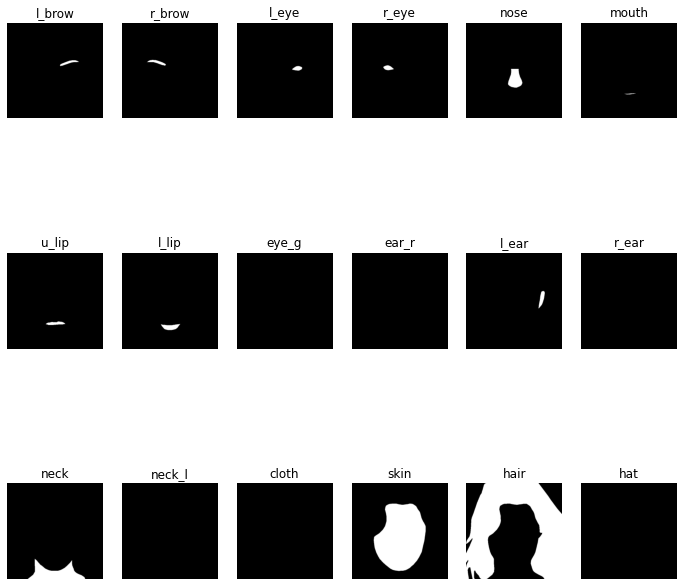

In [57]:
random_id = int(random.choice(_anno_ids))

_img_parts,_img_paths = get_parts(random_id)
img_list,parts_list = read_allParts(_img_parts,_img_paths)
print(random_id)
plotImages(img_list,parts_list)


## Create data pipeline

In [58]:
class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self,x_col,x_imgPath,batch_size, shuffle= True):

        self.x_col = x_col
        self.x_imgPath = x_imgPath
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        self.n = len(self.x_col)

        
    def on_epoch_end(self):
        pass
    
    
    
    
    def read_img(self,path):
        img = cv2.imread(path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
        
        #convert to tf and normalize
        tf_img = tf.cast(img, tf.float32)
        tf_img = (tf_img/127.5)-1
        return tf_img
    
    def create_emptyImage(self):
        img= np.zeros((IMG_WIDTH,IMG_HEIGHT,CHANNEL),dtype=int)
        tf_img = tf.cast(img, tf.float32)
        tf_img = (tf_img/127.5)-1
        return tf_img


    def get_parts(self,img_id):
        _img_parts = []
        _img_paths = []
        for anno_img_id,anno_path,anno_part  in zip(_anno_ids,_anno_paths,_anno_parts):

            if int(anno_img_id) == img_id:
                _img_paths.append(anno_path)
                _img_parts.append(anno_part)
        return _img_parts,_img_paths

    
    def read_allParts(self,_img_parts,_img_paths):
        """
         l_brow,r_brow,l_eye,r_eye,nose,mouth,
         u_lip,l_lip,eye_g,ear_r,l_ear,r_ear,
         neck,neck_l,cloth,skin,hair,hat
         """
        input_list = ["l_brow","r_brow","l_eye","r_eye","nose","mouth",
         "u_lip","l_lip","eye_g","ear_r","l_ear","r_ear",
         "neck","neck_l","cloth","skin","hair","hat"]
        img_list = []

        for cur_class in input_list:
            cur_class_imgPath = None
            for img_part,img_path in zip(_img_parts,_img_paths):

                if cur_class == img_part:
                    cur_class_imgPath = img_path
                    break

            if cur_class_imgPath is None:
                emptyImg = create_emptyImage(IMG_WIDTH,IMG_HEIGHT,CHANNEL)
                img_list.append(emptyImg)
            else:
                readImg = read_img(cur_class_imgPath)
                img_list.append(readImg)

        return img_list,input_list

    
    
    
    def __get_input(self,imageName):

        # Read an image from a file
        real_img_path = self.x_imgPath+"\\"+imageName
        real_imgID = int(imageName.split(".")[0])
        real_image = self.read_img(real_img_path)
        
        _img_parts,_img_paths = get_parts(real_imgID)
        mask_img_list,parts_list = read_allParts(_img_parts,_img_paths)
        return real_image,tuple(mask_img_list)
    
    
    
    def __get_data(self,x_batches,y_batches):
        img_batches,mask_batches =  [],[]
        for x_path, y_path in zip(x_batches,y_batches):
            real_image,mask_images = self.__get_input(x_path)
            img_batches.append(real_image)
            mask_batches.append(mask_images)
        img_batches = np.asarray(img_batches)
        
        
        empty_masks = np.empty(len(mask_batches),dtype=object)
        empty_masks[:] = mask_batches
        #mask_batches = np.asarray(mask_batches)
       
        return img_batches,empty_masks
        
        
    def __getitem__(self,index):
        X_batches = self.x_col[index*self.batch_size : (index+1)*self.batch_size]

        X,Y= self.__get_data(X_batches,X_batches)
        return X,Y
    
    
    def __len__(self):
        return self.n // self.batch_size

In [59]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
BUFFER_SIZE = 200
BATCH_SIZE = 6
OUTPUT_CHANNELS = 3
EPOCHS = 150
input_list = ["l_brow","r_brow","l_eye","r_eye","nose","mouth",
 "u_lip","l_lip","eye_g","ear_r","l_ear","r_ear",
 "neck","neck_l","cloth","skin","hair","hat"]

In [60]:
img_ids = os.listdir(img_path)
print("Total image ids : ",len(img_ids))
print("Total mask ids : ",len(_anno_paths))

Total image ids :  30000
Total mask ids :  372767


In [61]:
train_ids = img_ids[:29700]
val_ids = img_ids[29700:]

In [62]:
train_gen= CustomDataGen(x_col = train_ids,x_imgPath= img_path,batch_size=BATCH_SIZE)
test_gen= CustomDataGen(x_col = val_ids,x_imgPath= img_path,batch_size=BATCH_SIZE)

## Create model

{'cloth',
 'ear_r',
 'eye_g',
 'hair',
 'hat',
 'l_brow',
 'l_ear',
 'l_eye',
 'l_lip',
 'mouth',
 'neck',
 'neck_l',
 'nose',
 'r_brow',
 'r_ear',
 'r_eye',
 'skin',
 'u_lip'}

In [63]:
def downsample(filters,size,apply_batchnorm = True):
    initializer = tf.random_normal_initializer(0.,0.02)
    
    result = tf.keras.Sequential()
    
    result.add(tf.keras.layers.Conv2D(filters,size,strides = 2, padding='same',
                                     kernel_initializer = initializer,use_bias =False))
    
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    
    result.add(tf.keras.layers.LeakyReLU())
    
    
    return result

In [64]:
def upsample(filters,size,apply_dropout=False):
    initializer = tf.random_normal_initializer(0.,0.02)
    
    result = tf.keras.Sequential()
    
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,padding = 'same',
                                              kernel_initializer = initializer, use_bias = False)
              )
    
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    
    result.add(tf.keras.layers.ReLU())
    
    return result

In [65]:
def Generator():
    
    
    """
    {'cloth', 'ear_r', 'eye_g', 'hair', 'hat', 'l_brow',
     'l_ear', 'l_eye', 'l_lip', 'mouth', 'neck', 'neck_l',
     'nose', 'r_brow', 'r_ear', 'r_eye', 'skin', 'u_lip'}
     
     l_brow,r_brow,l_eye,r_eye,nose,mouth,u_lip,l_lip,eye_g,ear_r,l_ear,r_ear,neck,neck_l,cloth,skin,hair,hat
    """
    
    
        
    l_brow = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'l_brow')
    r_brow = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'r_brow')
    input1 = tf.keras.layers.concatenate([l_brow,r_brow],name = "l_r_brow")
    
    l_eye = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'l_eye')
    r_eye = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'r_eye')
    input2 = tf.keras.layers.concatenate([l_eye,r_eye],name = "l_r_eye")
    
    input12 = tf.keras.layers.concatenate([input1,input2],name = "input12")
    
    
    
    nose = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'nose')
    mouth = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'mouth')
    input3 = tf.keras.layers.concatenate([nose,mouth],name = "nose_mouth")
    
    u_lip = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'u_lip')
    l_lip = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'l_lip')
    input4 = tf.keras.layers.concatenate([u_lip,l_lip],name = "u_l_lip")
    
    input34 = tf.keras.layers.concatenate([input3,input4],name = "input34")
    
   
    eye_g = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'eye_g')
    ear_r = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'ear_r')
    input5 = tf.keras.layers.concatenate([eye_g,ear_r],name = "eye_g_ear_r")
 
    
    l_ear = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'l_ear')
    r_ear = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'r_ear')
    input6 = tf.keras.layers.concatenate([l_ear,r_ear],name = "l_r_ear")
    
    input56 = tf.keras.layers.concatenate([input5,input6],name = "input56")
    
    
    
    neck = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'neck')
    neck_l = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'neck_l')
    input7 = tf.keras.layers.concatenate([neck,neck_l],name = "neck_neck_l")
       
    cloth = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'cloth')
    skin = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'skin')
    input8 = tf.keras.layers.concatenate([cloth,skin],name = "cloth_skin")
    
    hair =  tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'hair')
    hat =  tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'hat')
    input9 = tf.keras.layers.concatenate([hair,hat],name = "hair_hat")
    
    input789 = tf.keras.layers.concatenate([input7,input8,input9],name = "input789")
    

    inputs = tf.keras.layers.concatenate([input12,input34,input56,input789])
    
    
    down_stack = [
        downsample( 128, 4, apply_batchnorm = False), # (bs, 128,128, 64)
        downsample(256,4),  # (bs, 64, 64, 128)
        downsample(512,4),  # (bs, 32, 32, 256)
        downsample(1024,4),  # (bs, 16, 16, 512)
        downsample(1024,4),  # (bs, 8, 8, 512)
        downsample(1024,4),  # (bs, 4, 4, 512)
        downsample(1024,4),  # (bs, 2, 2, 512)
        downsample(1024,4),  # (bs, 1, 1, 512)
        
    ]
    
    
    up_stack = [
        upsample(1024,4, apply_dropout = True), # (bs, 2,2, 1024)
        upsample(1024,4, apply_dropout = True), # (bs, 4,4, 1024)
        upsample(1024,4, apply_dropout = True), # (bs, 8,8, 1024)
        upsample(1024,4), # (bs, 16,16, 1024)
        upsample(512,4), # (bs, 32, 32,input_channels 512)
        upsample(256,4), # (bs,64, 64, 256)
        upsample(128,4),  # (bs, 128, 128, 128)
    ]
    
    
    initializer = tf.random_normal_initializer(0.,0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                          strides = 2,
                                          padding = 'same',
                                          kernel_initializer = initializer,
                                          activation = 'tanh') #(bs, 256,256, 3)
    
    x = inputs
    
    
    #Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
        
    skips = reversed(skips[:-1])
    
    #Upsampling and establishing the skip connections
    for up,skip in zip(up_stack,skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x,skip])
        
    x = last(x)
    
    return tf.keras.Model(inputs=[l_brow,r_brow,l_eye,r_eye,nose,mouth,u_lip,l_lip,eye_g,ear_r,l_ear,r_ear,neck,neck_l,cloth,skin,hair,hat],outputs= x)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 l_brow (InputLayer)            [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 r_brow (InputLayer)            [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 l_eye (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                          

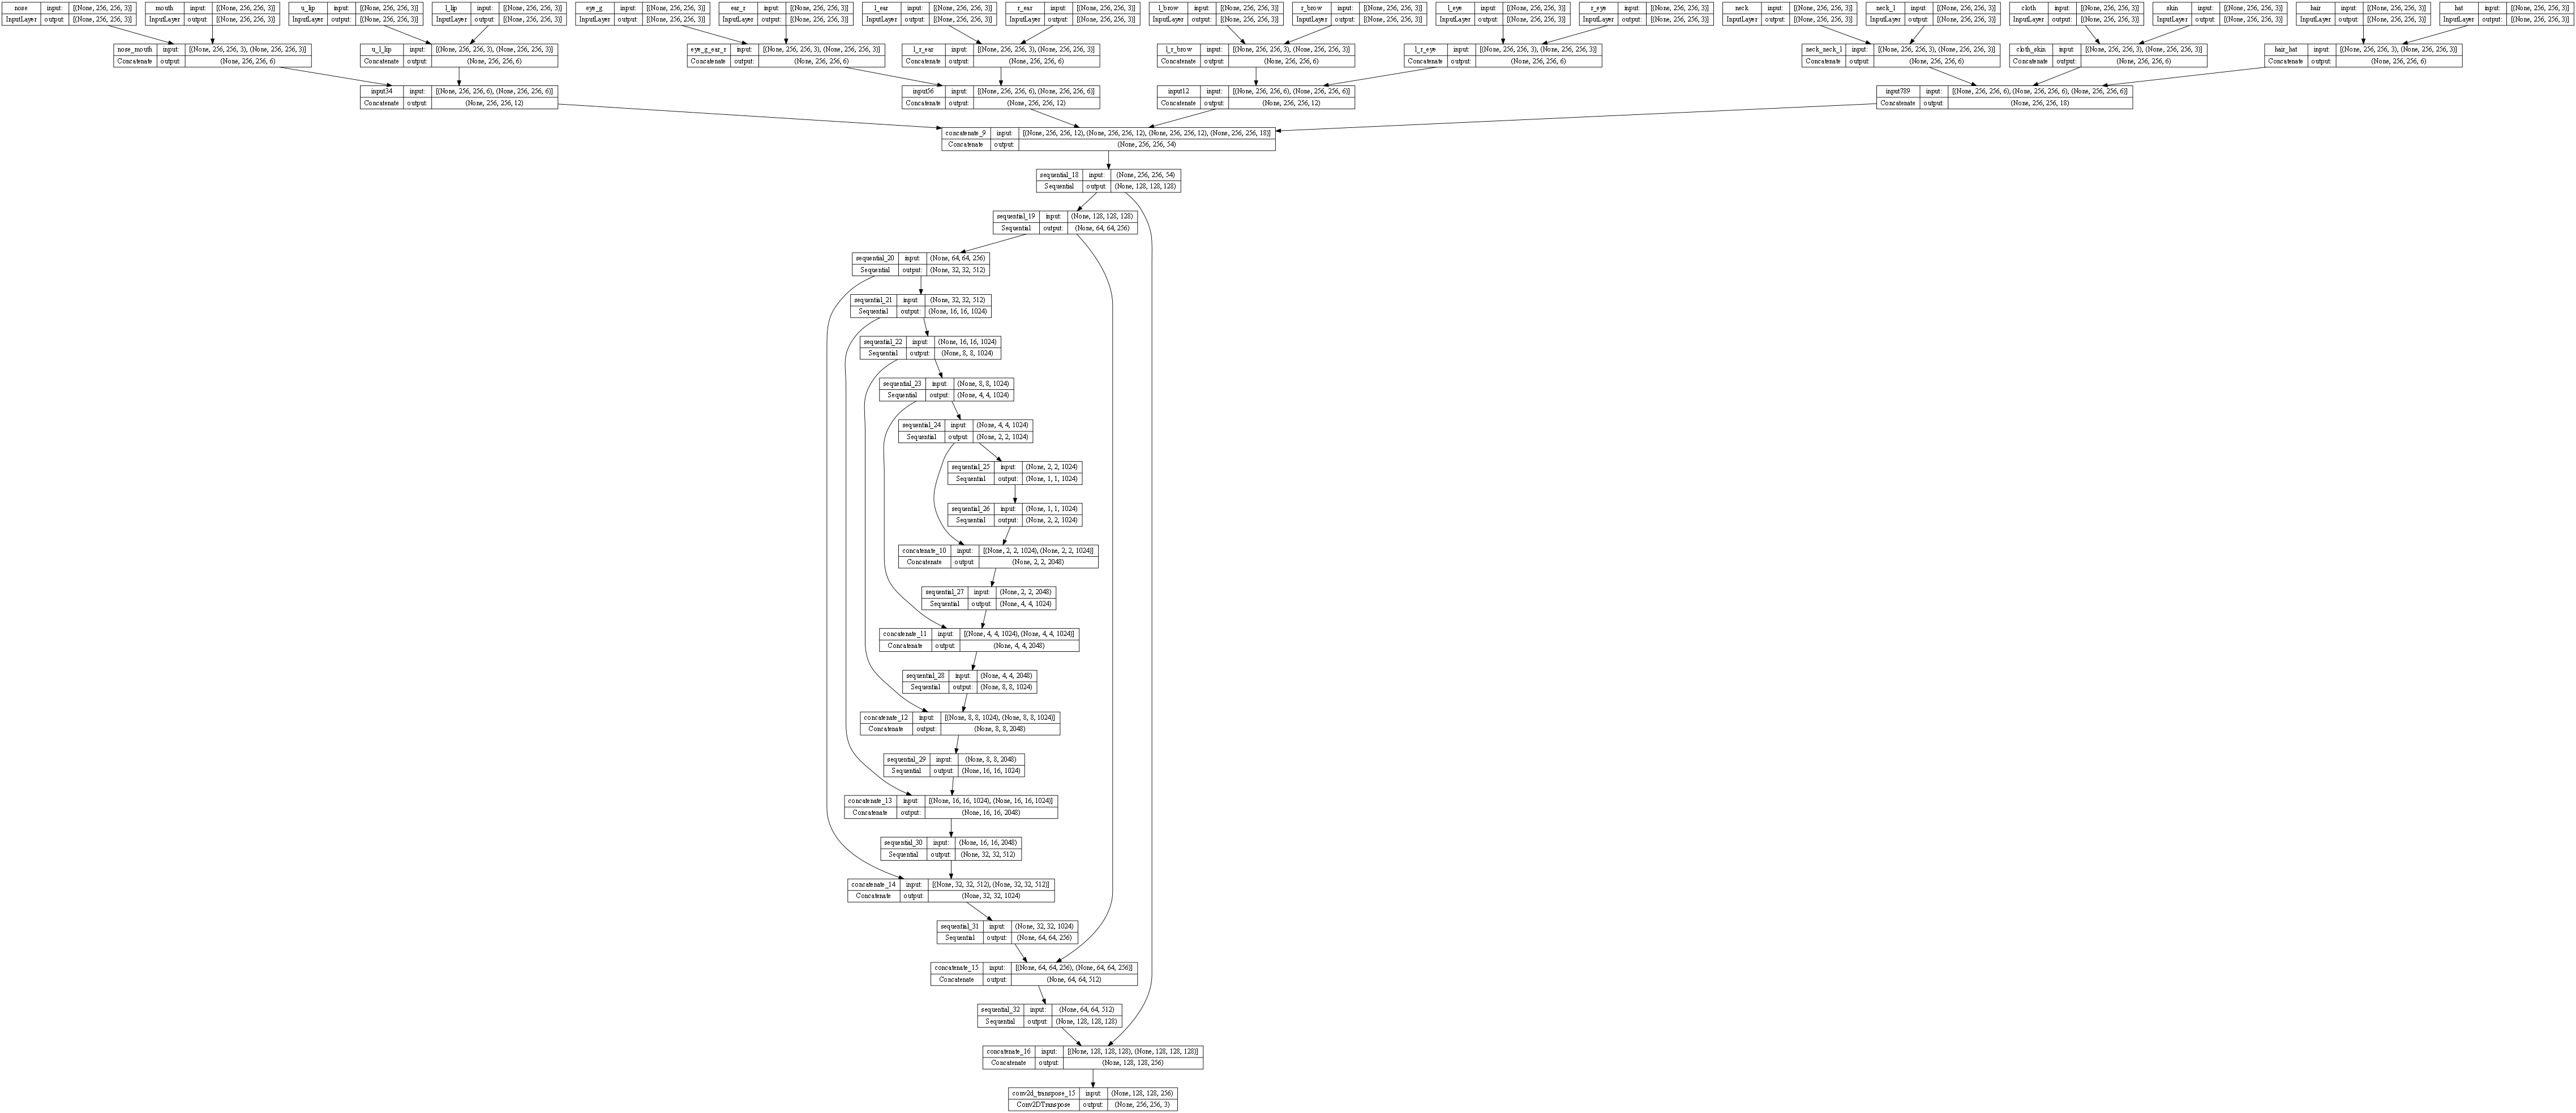

In [66]:
generator = Generator()
generator.summary()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [67]:
def generate_images(model,input_parts,tar):
    prediction = model(input_parts, training=True)
    pred_images = prediction[0]
    
    temp_parts_list = parts_list
    temp_parts_list.append("Ground Truth")
    temp_parts_list.append("Generated Image")
    temp_input_parts.append(tar)
    temp_input_parts.append(pred_images)

    plotImages(temp_input_parts,temp_parts_list)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
18


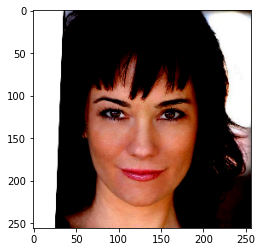

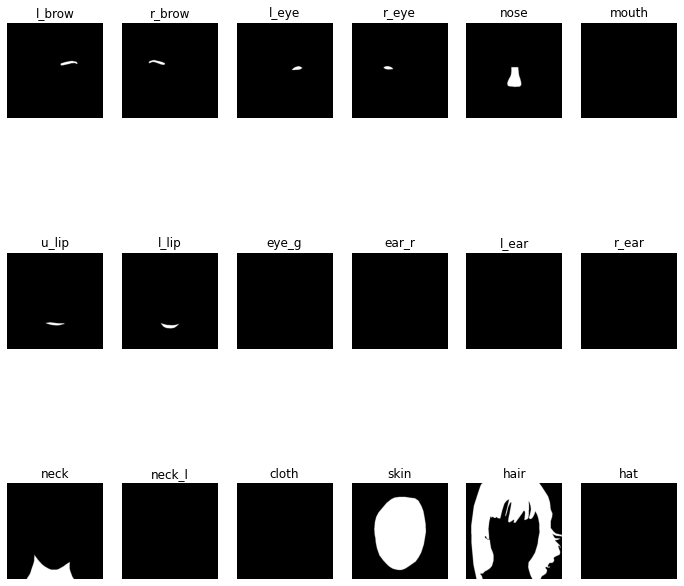

In [68]:
real_img, masks_lists  = train_gen.__getitem__(4)
test_img,test_segs = real_img[0],masks_lists[0]
print(test_img.shape)
print(len(test_segs))
plt.imshow(test_img)
plt.show()
plotImages(test_segs,parts_list)

In [69]:
#real_img,masks_lists  = train_gen.__get_input("1.jgp")
masks_lists.shape

(6,)

In [70]:
type(masks_lists[0])
img1,img2,img3,img4,img5,img6,img7,img8,img9,img10,img11,img12,img13,img14,img15,img16,img17,img18= masks_lists[0]
test_gen_input = [img1[tf.newaxis,...],img2[tf.newaxis,...],img3[tf.newaxis,...],img4[tf.newaxis,...],img5[tf.newaxis,...],img6[tf.newaxis,...],img7[tf.newaxis,...],img8[tf.newaxis,...],img9[tf.newaxis,...],img10[tf.newaxis,...],img11[tf.newaxis,...],img12[tf.newaxis,...],img13[tf.newaxis,...],img14[tf.newaxis,...],img15[tf.newaxis,...],img16[tf.newaxis,...],img17[tf.newaxis,...],img18[tf.newaxis,...]]
#print(test_gen_input)

(1, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


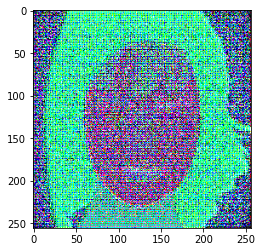

In [71]:
from operator import ge


gen_output = generator(test_gen_input,training=False)
print(gen_output.shape)
plt.imshow(gen_output[0])

## Discriminator network

In [72]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'input_image')
    tar = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'target_image')
    
    x = tf.keras.layers.concatenate([inp,tar]) # (bs, 256,256, channels*2)
    
    down1 = downsample(64,4, False)(x)  # (bs, 128,128,64)
    down2 = downsample(128,4)(down1)    # (bs, 64,64, 128)
    down3 = downsample(256,4)(down2)    # (bs, 32,32,256)
    
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34,34, 256)
    
    conv = tf.keras.layers.Conv2D(512, 4, strides = 1,
                                 kernel_initializer = initializer,
                                 use_bias = False)(zero_pad1) #(bs,31,31,512)
    
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) #(bs, 33,33,512)
    
    
    last = tf.keras.layers.Conv2D(1,4, strides=1,
                                 kernel_initializer = initializer)(zero_pad2)# (bs, 30, 30, 1)
    
    
    return tf.keras.Model(inputs = [inp,tar],outputs= last)

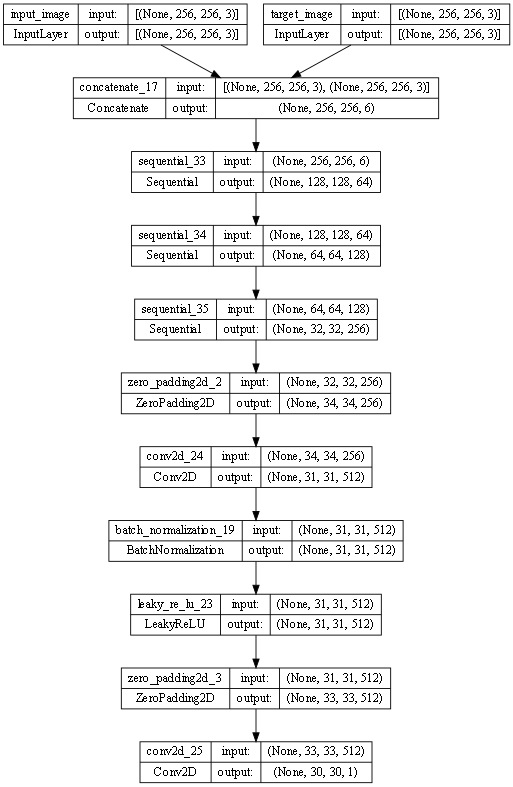

In [73]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test target img shape :  (256, 256, 3)
Test generated img shape :  (256, 256, 3)


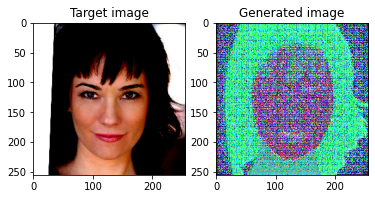

In [74]:
print("Test target img shape : ",test_img.shape)
print("Test generated img shape : ",gen_output[0].shape)

plt.subplot(1,2,1)
plt.title("Target image")
plt.imshow(test_img)

plt.subplot(1,2,2)
plt.title("Generated image")
plt.imshow(gen_output[0])
plt.show()


In [75]:
disc_out = discriminator([test_img[tf.newaxis,...], gen_output], training=False)
print(disc_out.shape)

(1, 30, 30, 1)


In [76]:
def generate_images(model, test_input, tar):
    
    img1,img2,img3,img4,img5,img6,img7,img8,img9,img10,img11,img12,img13,img14,img15,img16,img17,img18= test_input[0]
    test_gen_input = [img1[tf.newaxis,...],img2[tf.newaxis,...],img3[tf.newaxis,...],img4[tf.newaxis,...],img5[tf.newaxis,...],img6[tf.newaxis,...],img7[tf.newaxis,...],img8[tf.newaxis,...],img9[tf.newaxis,...],img10[tf.newaxis,...],img11[tf.newaxis,...],img12[tf.newaxis,...],img13[tf.newaxis,...],img14[tf.newaxis,...],img15[tf.newaxis,...],img16[tf.newaxis,...],img17[tf.newaxis,...],img18[tf.newaxis,...]]
    #test_gen_input = [(1,256,256,3).....]
    test_gen_input_img = (img1+img2+img3+img4+img5+img6+img7+img8+img9+img10+img11+img12+img13+img14+img15+img16+img17+img18)/255

    prediction = model(test_gen_input, training=True)
    plt.figure(figsize=(15,15))
    
    
    display_list = [test_gen_input_img, tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


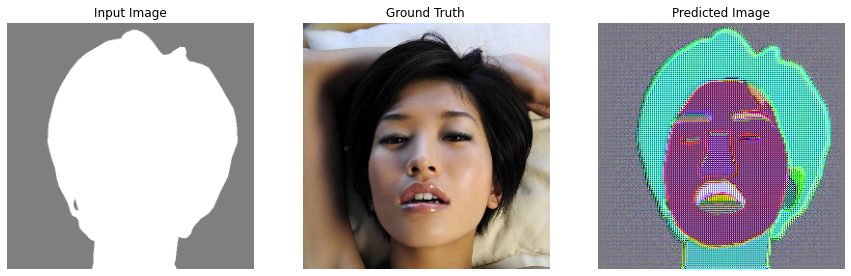

In [77]:
real_img, masks_lists  = train_gen.__getitem__(3)
generate_images(generator,masks_lists,real_img)

## model training

In [78]:
generator_optimizer =  tf.keras.optimizers.Adam(2e-4,beta_1= 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1 = 0.5)


In [81]:
loss_object =  tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [82]:
#Generator loss
LAMBDA = 100
def generator_loss(disc_generated_output, gen_output, target):
    gen_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    
    #mae loss
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    total_gen_loss = gen_loss + (LAMBDA * l1_loss)
    
    return total_gen_loss, gen_loss,l1_loss

In [83]:
def discriminator_loss(disc_real_output,disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    
    generated_loss = loss_object(tf.zeros_like(disc_generated_output),disc_generated_output)
    
    total_disc_loss = real_loss + generated_loss
    
    
    return total_disc_loss

In [79]:
checkpoint_dir = r'E:\deep_learning\ths_testing\mask_to_image_testing\celeA_mask_img\image_analysis\check_point'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [38]:


import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [39]:
@tf.function
def train_step(input_image,target,epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image,training = True)
        
        disc_real_output = discriminator([input_image,target],training = True)
        disc_generated_output = discriminator([input_image,gen_output], training=True)
        
        
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output,gen_output,target)
        
        disc_loss = discriminator_loss(disc_real_output,disc_generated_output)
        
        generator_gradients = gen_tape.gradient(gen_total_loss,
                                                generator.trainable_variables)
        
        discriminator_gradients = disc_tape.gradient(disc_loss,
                                                    discriminator.trainable_variables)
        
        
        generator_optimizer.apply_gradients(zip(generator_gradients,
                                                generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                   discriminator.trainable_variables))
        
        
        with summary_writer.as_default():
            tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
            tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
            tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
            tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [40]:
print("trainIndex : ",train_gen.__len__())
print("testIndex :",test_gen.__len__())


trainIndex :  4950
testIndex : 50


In [41]:
def fit(train_generator,val_generator,epochs):
    for epoch in range(epochs):
        start = time.time()
        display.clear_output(wait = True)
        
        
        test_img,test_seg = val_generator.__getitem__(1)
      
       
        generate_images(generator,test_input=test_seg,tar=test_img)
        
        print("Epoch :",epoch)
        for i in range(1,train_generator.__len__(),1):
            print(".",end='')
            if (i+1)%100 ==0:
                print()
            img,seg = train_generator.__getitem__(i)
            train_step(seg,img,epoch)
        print()
        
        # saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
    checkpoint.save(file_prefix = checkpoint_prefix) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


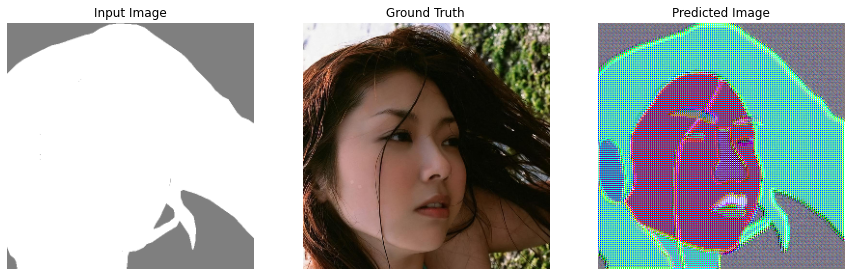

Epoch : 0
.

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type tuple).

In [86]:
fit(train_gen,test_gen, EPOCHS)

In [85]:
EPOCHS

150